In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tick
import tick.hawkes as hp
from scipy.optimize import minimize
import Hawkes as hk

In [2]:
np.random.beta(1, 0.2, 100)

array([0.96856406, 0.46982741, 0.99573952, 0.85690078, 0.73383471,
       0.9674034 , 0.99969246, 0.99999999, 0.99800667, 0.76540344,
       0.99631801, 0.7179625 , 0.96356899, 0.59681847, 0.85005119,
       0.9229987 , 0.9993974 , 0.99958443, 0.99994701, 0.8618657 ,
       0.88188317, 0.98496988, 0.97489366, 0.20819159, 0.99529414,
       0.37532907, 0.95003345, 0.39837887, 0.197718  , 1.        ,
       0.96800364, 1.        , 0.94907254, 0.99519182, 0.99953549,
       0.71481112, 0.83962257, 0.85210914, 0.70052176, 0.99909245,
       0.72790373, 0.85828881, 0.21993923, 0.55463025, 0.87254049,
       0.47258005, 0.98280066, 0.74789242, 0.93220315, 0.9980811 ,
       0.99992593, 0.6621879 , 0.22318493, 0.90609428, 0.83453579,
       0.98368262, 0.95931466, 0.81092058, 0.40883266, 1.        ,
       0.99647373, 0.85797944, 0.54241838, 0.97855344, 0.65706591,
       1.        , 0.98220256, 0.22068633, 0.84131408, 0.99992194,
       0.99999814, 0.12830277, 0.23058981, 0.07965895, 0.95984

# Understanding Maximum Likelihood estimation

## Understanding normal distributions

In [203]:
def normal_distribution(x, mu=0, sigma=1):
    """
    A 1 dimensional normal distribution.
    """
    return (1/(np.sqrt(2*np.pi)*sigma))*np.exp(-((x - mu)**2)/(2*sigma**2))

In [204]:
x = np.linspace(-10, 11, 1000)
y = normal_distribution(x)

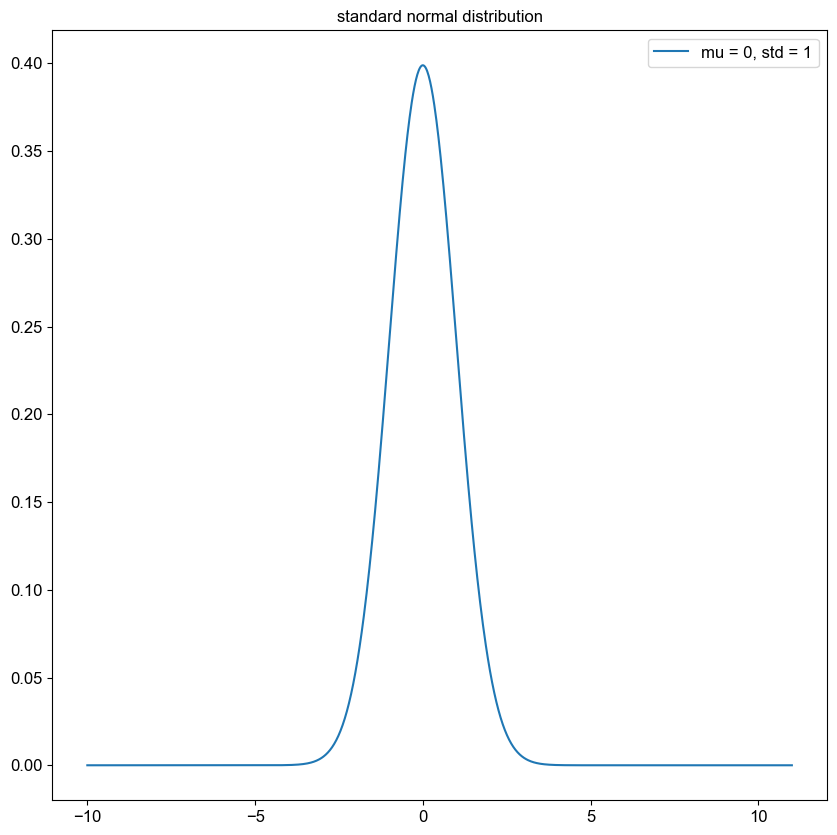

In [205]:
plt.figure(figsize=(10,10))
plt.plot(x, y, label="mu = 0, std = 1")
plt.title("standard normal distribution")
plt.legend(loc="best")
plt.show()

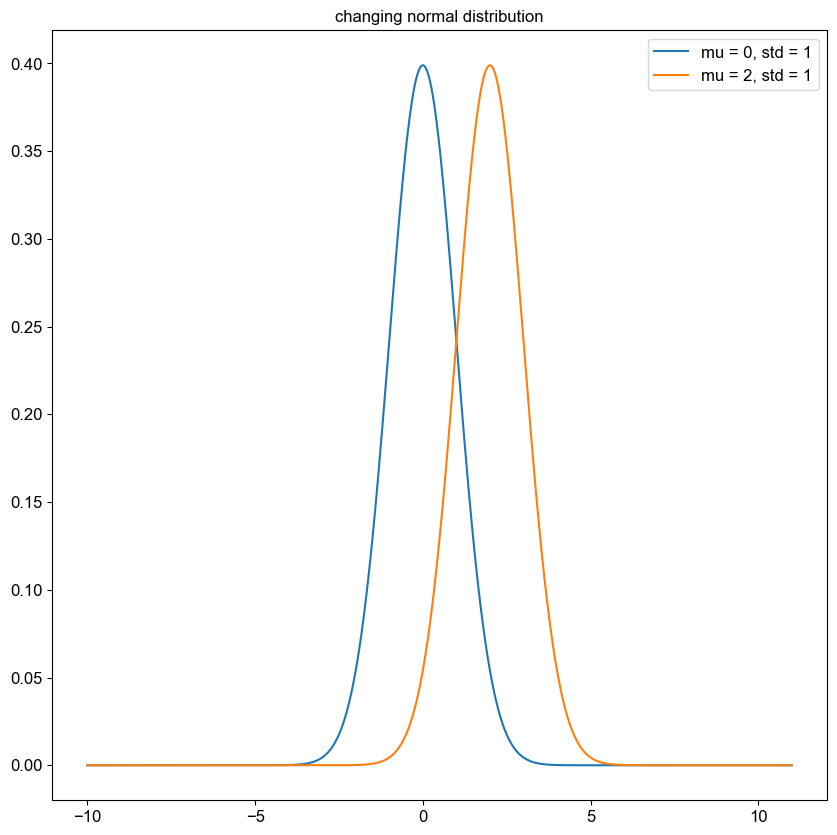

In [206]:
# we can shift the mean

x = np.linspace(-10, 11, 1000)
y1 = normal_distribution(x, mu=2)

plt.figure(figsize=(10,10))
plt.plot(x, y, label = "mu = 0, std = 1")
plt.plot(x, y1, label="mu = 2, std = 1")
plt.title("changing normal distribution")
plt.legend(loc="best")
plt.show()

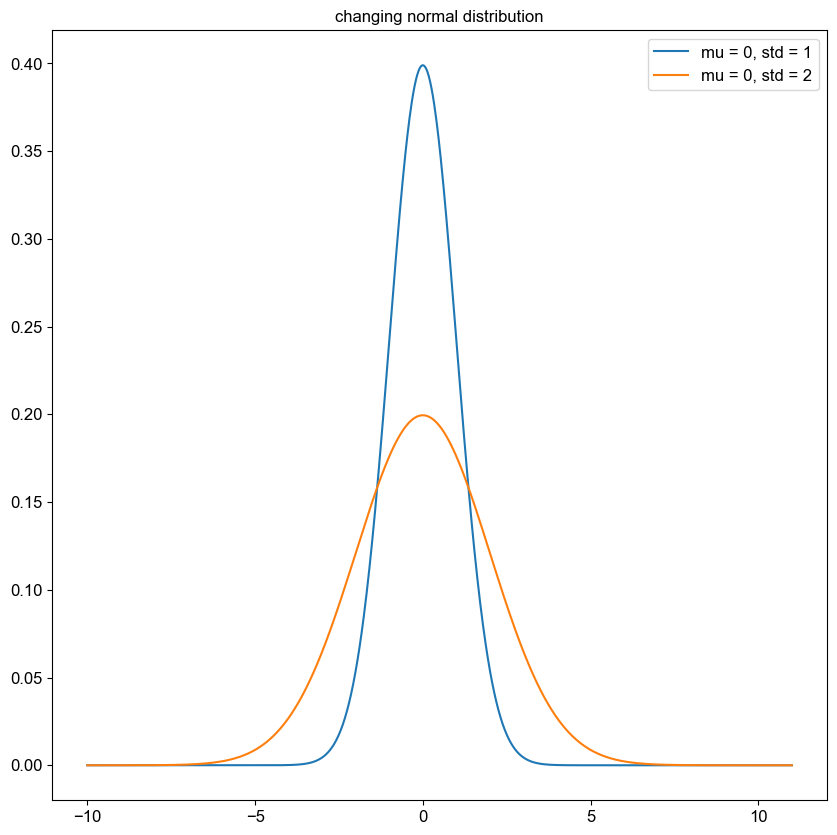

In [207]:
# we can change the standard deviation

x = np.linspace(-10, 11, 1000)
y3 = normal_distribution(x, sigma = 2)

plt.figure(figsize=(10,10))
plt.plot(x, y, label = "mu = 0, std = 1")
plt.plot(x, y3, label="mu = 0, std = 2")
plt.title("changing normal distribution")
plt.legend(loc="best")
plt.show()

## Maximum likelihood fitting

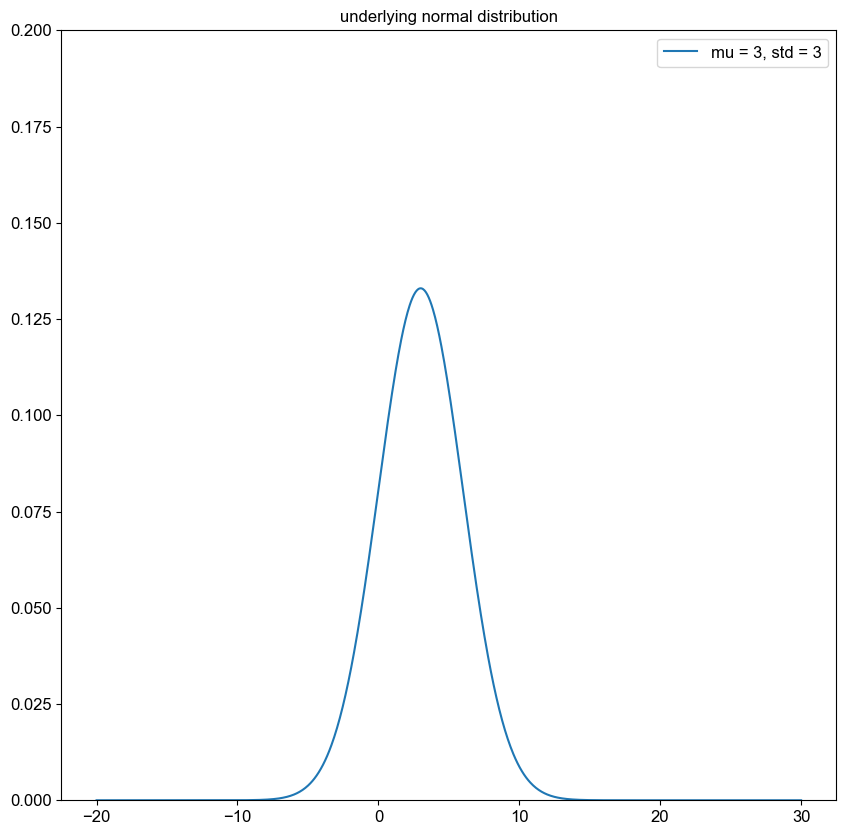

In [208]:
# sample points from a random normal distribution and perform maximum likelihood fits

# define the underlying distribution
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="mu = 3, std = 3")
plt.title("underlying normal distribution")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

## Deriving maximum likelihood estimators for normal distribution


The probability density function (PDF) of the normal distribution is given below.

$$f(x) = \frac{1}{\sqrt{2\pi}\sigma} e^{\frac{-(x-\mu)^{2}}{2\sigma^{2}}}$$

We have defined our ground truth function to be:
$$f(x | \mu = 3, \sigma = 3) = \frac{1}{3\sqrt{2\pi}} e^{\frac{-(x-3)^{2}}{18}}$$

$f(x | \mu, \sigma)$ can also be denoted $f(x ; \mu, \sigma)$.

A common mistake is interpreting the codomain of a PDF to represent a space of probabilities, but this is not the case. A simple check is to substitute a number into the PDF and sanity check it's output. We know that the probability of observing any given value for a continuous random variable should be zero. Substituting the mean value (3) into our ground truth normal distribution gives us:

$$f(3) \sim 0.13298...$$

Thus, we see that this value cannot represent a probability. What exactly does this represent? Well, the PDF actually tells us the "relative likelihood" of a value being observed. Note that the relative term refers to the fact that these likelihood values cannot be compared between different PDFs, but only between two values of the same PDF. It gives us some sort of measure which describes which values are more likely to occur, and therefore can tell us how well an observation fits our assumed distribution. Following from this logic, we can define the likelihood function, which describes the likelihood of observing a set of points $x_{1}, x_{2}, ..., x_{n}$, assuming the parameters of the distribution as $\mu, \sigma$ or $\theta$ in general as:

$$\mathcal{L}(\theta | X) = \mathcal{L}(\mu, \sigma | X) = \prod_{i=1}^{n} f(x_{i} | \mu, \sigma)$$

Commonly, we use the log of this function instead, as the product of many relative likelihoods which are, in general, quite small. This usually results in a very small likelihood, which can be less informative than the log of that value. Also, the log has another nice property - it changes the product into a summation, which can be differentiated easily without changing the the location of the maxima.

$$ log \mathcal{L}(\mu, \sigma | X) = \sum_{i=1}^{n} log f(x_{i} | \mu, \sigma)$$

In [209]:
class LikelihoodFunction:
    """
    Finds the likelihood value of a set of observations
    """
    def __init__(self, probability_distribution, *dist_args, **dist_kwargs) -> None:
        self._probability_distribution = lambda x : probability_distribution(x, **dist_kwargs)

    def compute_likelihood(self, X):
        lh = self._probability_distribution(X).prod()
        return lh

In [210]:
class LogLikelihoodFunction(LikelihoodFunction):
    def __init__(self, probability_distribution, *dist_args, **dist_kwargs) -> None:
        super().__init__(probability_distribution, *dist_args, **dist_kwargs)

    def compute_likelihood(self, X):
        return np.log(super().compute_likelihood(X))

The maximum likelihood estimator (MLE) is a function which solves for the parameters which maximise the likelihood function. The MLE describes each parameter as a function of the observations. Below we derive the MLE for both the mean and standard deviation of our normal distribution.

$$\mathcal{L}(\mu, \sigma | X) = \prod_{i=1}^{n} \frac{1}{\sqrt{2\pi}\sigma} e^{\frac{-(x_{i}-\mu)^{2}}{2\sigma^{2}}}$$

$$\log \mathcal{L}(\mu, \sigma | X) = \sum_{i=1}^{n} \log \biggl[\frac{1}{\sqrt{2\pi}\sigma} e^{\frac{-(x_{i}-\mu)^{2}}{2\sigma^{2}}}\biggr]$$

$$\log \mathcal{L}(\mu, \sigma | X) = \sum_{i=1}^{n} -\log{\sqrt{2\pi}\sigma} - \frac{(x_{i} - \mu)^{2}}{2\sigma^{2}}$$

Since the likelihood function of the normal distribution is concave with respect to its parameters, we can simply find the maximum by differentiating and setting to zero.

$$\frac{d\log \mathcal{L}(\mu, \sigma | X)}{d\sigma} = \sum_{i=1}^{n} -\frac{1}{\sigma} + \frac{(x_{i} - \mu)^{2}}{\sigma^{3}} = -\frac{n}{\sigma} + \sum_{i=1}^{n} \frac{(x_{i} - \mu)^{2}}{\sigma^{3}} = 0$$

$$\implies \sigma^{2} = \frac{1}{n} \sum_{i=1}^{n} (x_{i} - \mu)^{2}$$

$$\frac{d\log \mathcal{L}(\mu, \sigma | X)}{d\mu} = \sum_{i=1}^{n} \frac{x_{i} - \mu}{\sigma^{2}} = \biggl(\sum_{i=1}^{n} x_{i}\biggr) - n\mu = 0$$

$$\implies \mu = \frac{1}{n} \sum_{i=1}^{n} x_{i} $$

In [211]:
def variance_maximum_likelihood_estimator(observations, mu):
    var = np.average((observations - mu)**2)
    return var

def mean_maximum_likelihood_estimator(observations):
    mu = np.average(observations)
    return mu

In [212]:
# Add experimental data

observations = np.random.normal(loc=3, scale=3, size=5)

In [213]:
mses = []

In [214]:
mu = mean_maximum_likelihood_estimator(observations)
var = variance_maximum_likelihood_estimator(observations, mu)

In [215]:
mses += [np.sqrt((3 - mu)**2 + (3 - np.sqrt(var))**2)]

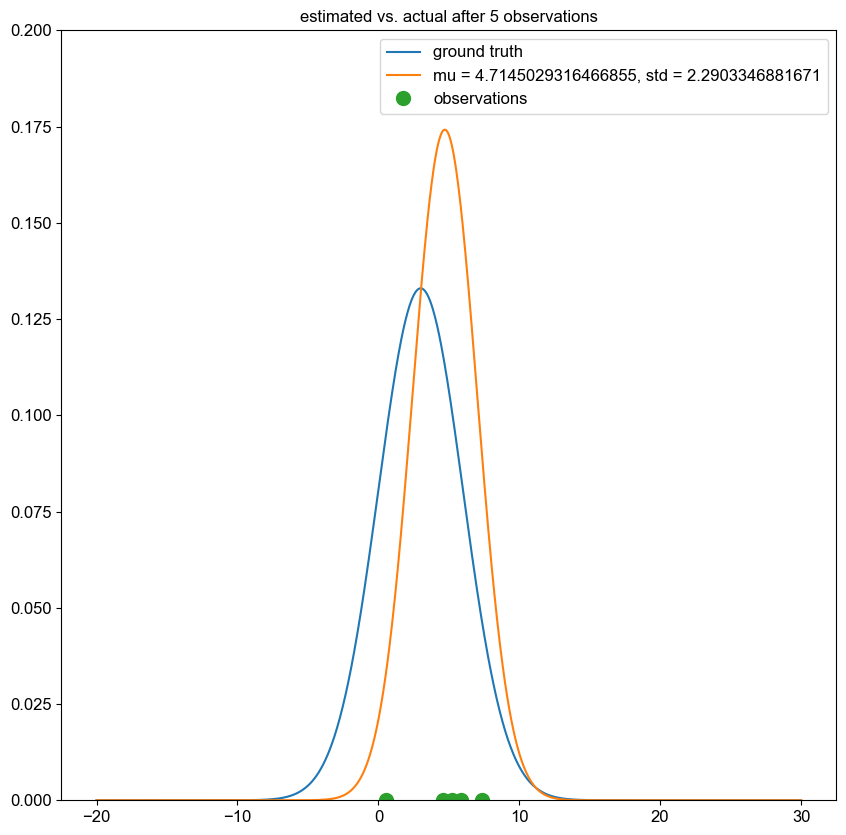

In [216]:
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)
estimated = normal_distribution(x, mu = mu, sigma=np.sqrt(var))

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="ground truth")
plt.plot(x, estimated, label=f"mu = {mu}, std = {np.sqrt(var)}")
plt.plot(observations, [0]*observations.shape[0], 'o', markersize=10, label="observations")
plt.title("estimated vs. actual after 5 observations")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

In [217]:
observations = np.concatenate([observations, np.random.normal(loc=3, scale=3, size=5)])

In [218]:
mu = mean_maximum_likelihood_estimator(observations)
var = variance_maximum_likelihood_estimator(observations, mu)

In [219]:
mses += [np.sqrt((3 - mu)**2 + (3 - np.sqrt(var))**2)]

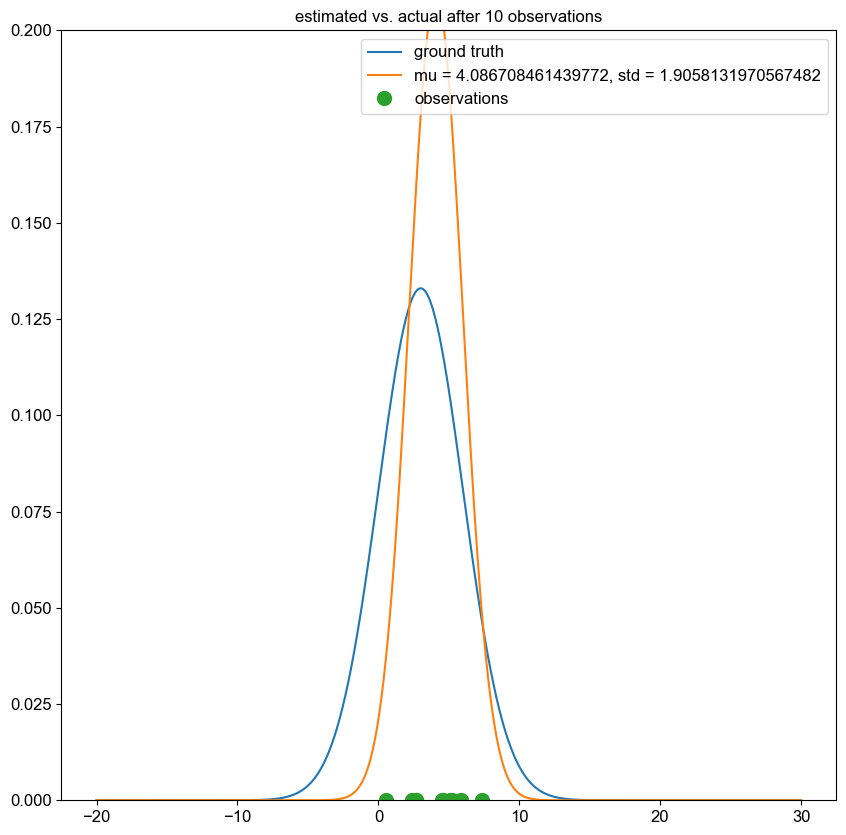

In [220]:
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)
estimated = normal_distribution(x, mu = mu, sigma=np.sqrt(var))

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="ground truth")
plt.plot(x, estimated, label=f"mu = {mu}, std = {np.sqrt(var)}")
plt.plot(observations, [0]*observations.shape[0], 'o', markersize=10, label="observations")
plt.title("estimated vs. actual after 10 observations")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

In [221]:
observations = np.concatenate([observations, np.random.normal(loc=3, scale=3, size=40)])

In [222]:
mu = mean_maximum_likelihood_estimator(observations)
var = variance_maximum_likelihood_estimator(observations, mu)

In [223]:
mses += [np.sqrt((3 - mu)**2 + (3 - np.sqrt(var))**2)]

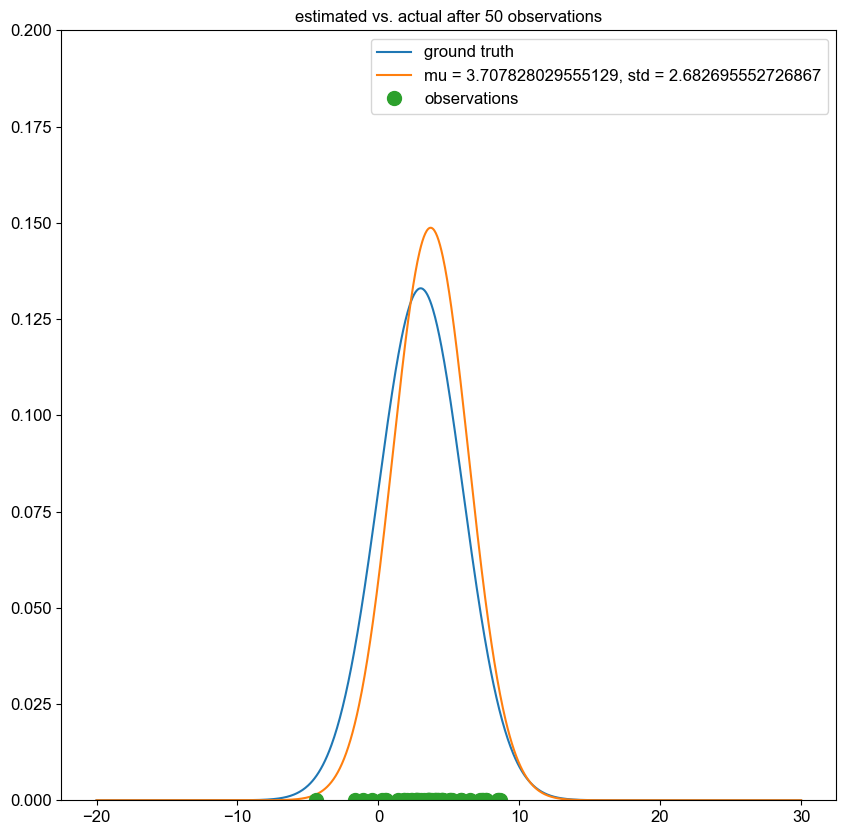

In [224]:
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)
estimated = normal_distribution(x, mu = mu, sigma=np.sqrt(var))

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="ground truth")
plt.plot(x, estimated, label=f"mu = {mu}, std = {np.sqrt(var)}")
plt.plot(observations, [0]*observations.shape[0], 'o', markersize=10, label="observations")
plt.title("estimated vs. actual after 50 observations")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

In [225]:
observations = np.concatenate([observations, np.random.normal(loc=3, scale=3, size=100)])

mu = mean_maximum_likelihood_estimator(observations)
var = variance_maximum_likelihood_estimator(observations, mu)

In [226]:
mses += [np.sqrt((3 - mu)**2 + (3 - np.sqrt(var))**2)]

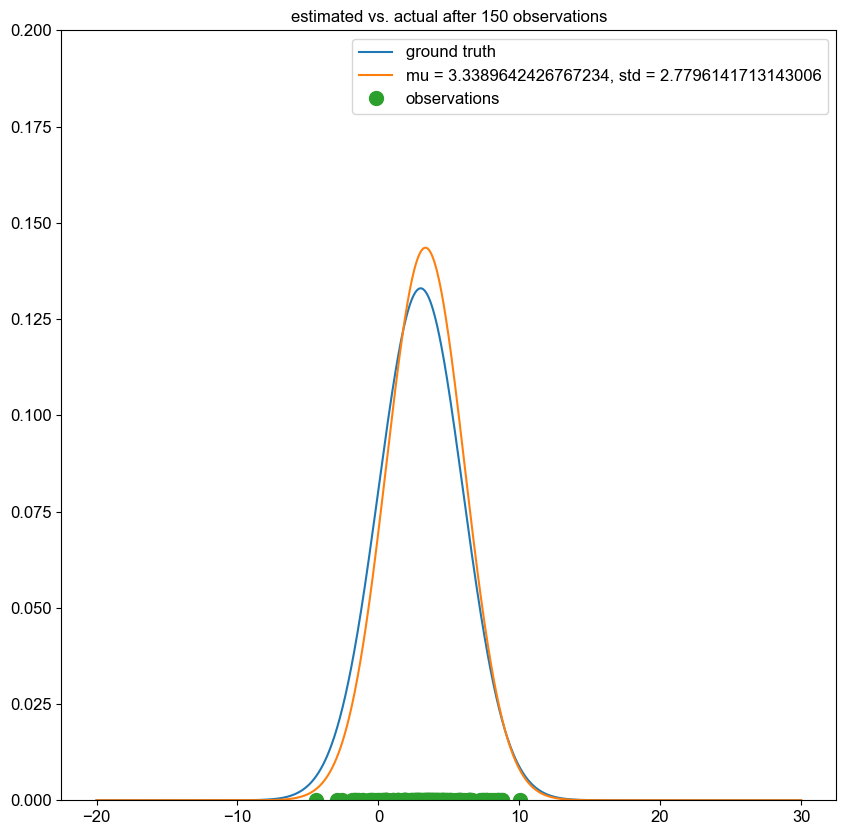

In [227]:
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)
estimated = normal_distribution(x, mu = mu, sigma=np.sqrt(var))

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="ground truth")
plt.plot(x, estimated, label=f"mu = {mu}, std = {np.sqrt(var)}")
plt.plot(observations, [0]*observations.shape[0], 'o', markersize=10, label="observations")
plt.title("estimated vs. actual after 150 observations")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

In [228]:
observations = np.concatenate([observations, np.random.normal(loc=3, scale=3, size=850)])

mu = mean_maximum_likelihood_estimator(observations)
var = variance_maximum_likelihood_estimator(observations, mu)

In [229]:
mses += [np.sqrt((3 - mu)**2 + (3 - np.sqrt(var))**2)]

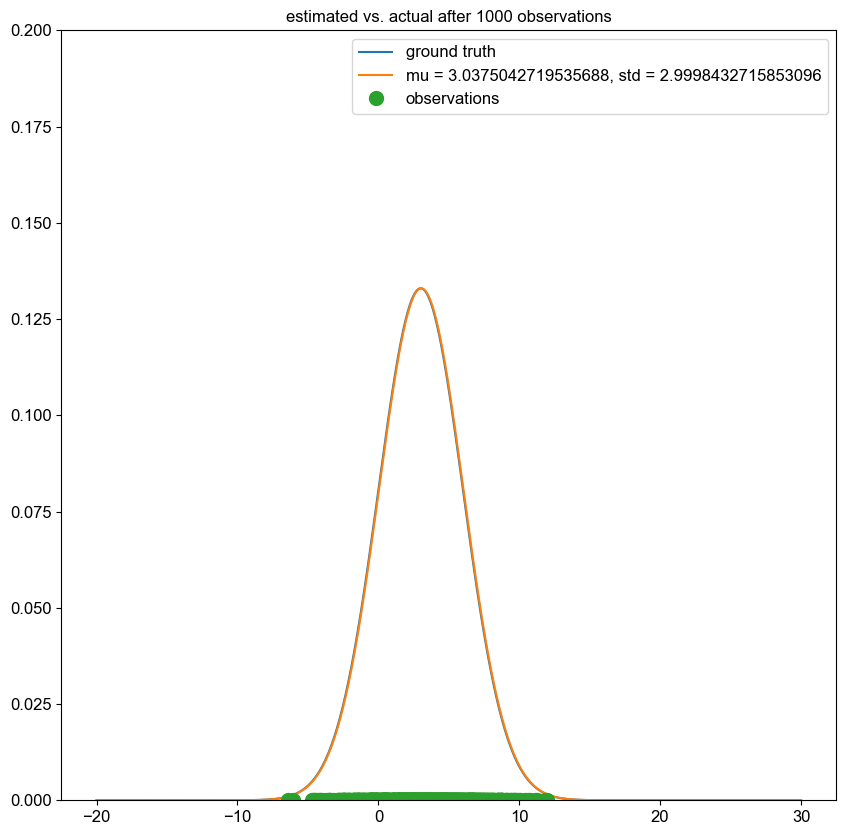

In [230]:
x = np.linspace(-20, 30, 1000)
truth = normal_distribution(x, mu = 3, sigma = 3)
estimated = normal_distribution(x, mu = mu, sigma=np.sqrt(var))

plt.figure(figsize=(10,10))
plt.plot(x, truth, label="ground truth")
plt.plot(x, estimated, label=f"mu = {mu}, std = {np.sqrt(var)}")
plt.plot(observations, [0]*observations.shape[0], 'o', markersize=10, label="observations")
plt.title("estimated vs. actual after 1000 observations")
plt.ylim(0, 0.2)
plt.legend(loc="best")
plt.show()

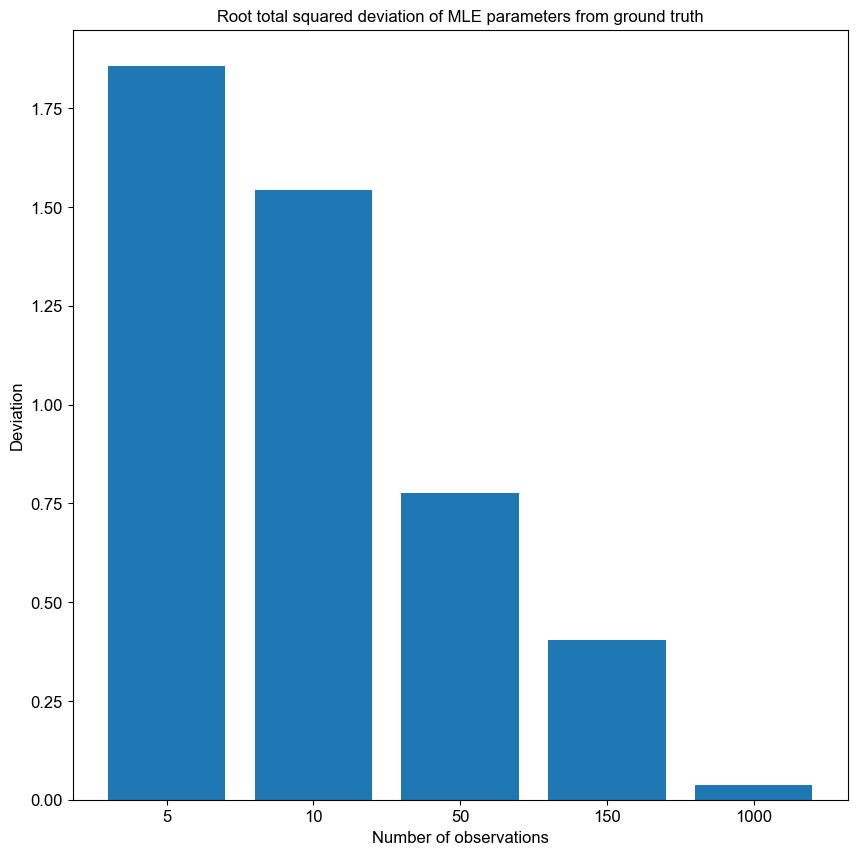

In [239]:
plt.figure(figsize=(10,10))
plt.bar(range(len(mses)), mses)

plt.title("Root total squared deviation of MLE parameters from ground truth")
plt.ylabel("Deviation")
plt.xlabel("Number of observations")

plt.xticks(range(len(mses)), [5, 10,50, 150, 1000])

plt.show()

As we can see, the more observations we add, the closer the estimated distribution lies to the ground truth.

# Maximum likelihood estimation of Hawkes Process

https://www.youtube.com/watch?v=42zJ5xrdOqo

Derive the approximation for the intensity function at point a using Taylor's theorem. Then, calculate gradient and hessian at point. Use this to iterate through and optimise a multidiemnsional function.

In [2]:
def calculate_A_matrix(i, events, beta):
    if i == 0: return 0
    time_diffs = events[i] - events[:i]
    return np.exp(-beta*(time_diffs)).sum()

def calculate_B_matrix(i, events, beta):
    if i == 0: return 0
    time_diffs = events[i] - events[:i]
    return (time_diffs*np.exp(-beta*(time_diffs))).sum()

def calculate_C_matrix(i, events, beta):
    if i == 0: return 0
    time_diffs = events[i] - events[:i]
    return (np.exp(-beta*(time_diffs))*time_diffs**2).sum()

In [3]:
def gradient_of_alpha(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event_time = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        vec[i] += np.exp(-beta*(last_event_time - events[i])) - 1
        vec[i] += beta*A/(mu + beta*alpha*A)
    
    return vec.sum()

In [4]:
def gradient_of_beta(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event_time = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)
        time_until_last = last_event_time - events[i]

        vec[i] -= alpha * time_until_last * np.exp(-beta*(time_until_last))
        vec[i] -= alpha*beta*B/(mu + alpha*beta*A)
        vec[i] += (alpha*A)/(mu + beta*alpha*A)
    
    return vec.sum()

In [5]:
def gradient_of_mu(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event_time = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        vec[i] += 1/(mu + beta*alpha*A)
    
    return vec.sum() - last_event_time

In [24]:
def calculate_gradient(initial_guess, events):
    """
    provide initial guess as a vector of alpha, beta, mu
    """
    alpha = initial_guess[0]
    beta = initial_guess[1]
    mu = initial_guess[2]

    gradients = np.array([gradient_of_alpha(beta, alpha, mu, events),
                          gradient_of_beta(beta, alpha, mu, events),
                          gradient_of_mu(beta, alpha, mu, events)])
    return -gradients/events.shape[0]

In [25]:
def log_likelihood(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        time_until_last = last_event - events[i]

        vec[i] += alpha*(np.exp(-beta*time_until_last) - 1)
        vec[i] += np.log(mu + alpha*beta*A)
        
    return (vec.sum() - mu*last_event)/n

In [26]:
def maximise_llh(guess, *args):
    alpha = guess[0]
    beta = guess[1]
    mu = guess[2]
    return - log_likelihood(beta, alpha, mu, *args)

# Method of moments

In [87]:
final_time = 10000

In [134]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'alpha':0.4, 'beta':0.6, 'mu':0.2}
model.set_parameter(para)
itv = [0,final_time] # the observation interval
events = model.simulate(itv)
model.plot_l() 

In [135]:
events

array([1.52789889e+00, 3.23461274e+00, 1.94172290e+01, ...,
       9.99706315e+03, 9.99706465e+03, 9.99997666e+03])

In [146]:
def theoretical_moments(x, tau):
    alpha = x[0]*x[1]
    beta = x[1]
    mu = x[2]

    exp_intensity = mu/(1-alpha/beta)
    first_moment = tau*exp_intensity

    kappa = 1/(1-alpha/beta)
    gamma = beta-alpha
    second_moment = exp_intensity*(tau*kappa**2 + (1 - kappa**2)*(1 - np.exp(-tau*gamma))/gamma)
    return np.array([first_moment, second_moment])

In [147]:
from scipy.stats import moment

In [148]:
def sliding_window_moments(events, final_time, tau=1):
    tau = int(final_time/2000)
    bins = np.arange(0, final_time+1, 1)
    res = np.bincount(np.digitize(events, bins))

    counts = [res[i : i+tau].sum() for i in range(final_time - tau)]
    n = len(counts)
    return np.array([np.mean(counts), moment(counts, 2)])

In [149]:
def find_emperical_moments(events, final_time, tau=1):

    counts = np.zeros(int(final_time/tau))
    bins = np.arange(0, final_time+1, tau)
    res = np.digitize(events, bins)
    _, count = np.unique(res, return_counts=True)

    counts[:count.shape[0]] = count

    return np.array([np.mean(counts), moment(counts, 2)])

In [150]:
dt = 1

In [151]:
emp = find_emperical_moments(events, 2000, tau=dt)
emp

array([1.64250000e+00, 3.50112769e+03])

In [152]:
def scipy_wrapper(x, tau, events):
    return np.sum([((theoretical_moments(x, tau/i) - find_emperical_moments(events, 20000, tau=tau/i))**2).sum() for i in range(100,1000,100)])

In [153]:
from scipy.optimize import least_squares

In [154]:
x0 = np.array([1.2,1,1])

res = least_squares(scipy_wrapper, x0, args=(2000, events))

In [155]:
res.x

array([0.68626976, 0.23508189, 0.0570252 ])

In [32]:
final_guess = None

In [33]:
initial_guess = np.array([1,1,1])

final_guess = minimize(maximise_llh, initial_guess, events, jac=calculate_gradient, options={'return_all':True}, method="CG")

In [34]:
final_guess.x

array([0.72302911, 1.03615267, 0.57596231])

In [120]:
def second_derivative_alpha_alpha(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        vec[i] += (A/(mu + alpha*A))**2
        
    return - vec.sum()/n

In [121]:
def second_derivative_alpha_beta(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event_time = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)
        time_until_last = last_event_time - events[i]

        vec[i] -= (1/beta)*(time_until_last)*np.exp(-beta*time_until_last)
        vec[i] -= (1/beta**2)*(np.exp(-beta*time_until_last) - 1)

        vec[i] -= B/(mu + alpha*A)
        vec[i] += alpha*B*A/(mu + alpha*A)**2
        
    return vec.sum()/n

In [122]:
def second_derivative_beta_beta(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)
    last_event_time = events[-1]

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)
        C = calculate_C_matrix(i, events, beta)
        time_until_last = last_event_time - events[i]

        vec[i] += (alpha/beta)*(time_until_last**2)*np.exp(-beta*time_until_last)
        vec[i] += (2*alpha/beta**2)*(time_until_last)*np.exp(-beta*time_until_last)
        vec[i] += (2*alpha/beta**3)*(np.exp(-beta*time_until_last) - 1)

        vec[i] += alpha*C/(mu + alpha*A)
        vec[i] -= (alpha*B/(mu + alpha*A))**2
        
    return vec.sum()/n

In [123]:
def second_derivative_mu_mu(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)

        vec[i] -= 1/(mu + alpha*A)**2
        
    return vec.sum()/n

In [124]:
def second_derivative_mu_alpha(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)

        vec[i] -= A/(mu + alpha*A)**2
        
    return vec.sum()/n

In [125]:
def second_derivative_mu_beta(beta, alpha, mu, events):
    n = events.shape[0]
    vec = np.zeros(n)

    for i in range(n):
        A = calculate_A_matrix(i, events, beta)
        B = calculate_B_matrix(i, events, beta)

        vec[i] += alpha*B/(mu + alpha*A)**2
        
    return vec.sum()/n

In [197]:
def perform_newton_iteration(initial_guess, events):
    """
    provide initial guess as a vector of alpha, beta, mu
    """
    alpha = initial_guess[0]
    beta = initial_guess[1]
    mu = initial_guess[2]

    gradients = np.array([gradient_of_alpha(beta, alpha, mu, events),
                          gradient_of_beta(beta, alpha, mu, events),
                          gradient_of_mu(beta, alpha, mu, events)])

    log_like = log_likelihood(beta, alpha, mu, events)
    
    hessian = np.array([[second_derivative_alpha_alpha(beta, alpha, mu, events),
                         second_derivative_alpha_beta(beta, alpha, mu, events),
                         second_derivative_mu_alpha(beta, alpha, mu, events)],
                         [second_derivative_alpha_beta(beta, alpha, mu, events),
                          second_derivative_beta_beta(beta, alpha, mu, events),
                          second_derivative_mu_beta(beta, alpha, mu, events)],
                          [second_derivative_mu_alpha(beta, alpha, mu, events),
                           second_derivative_mu_beta(beta, alpha, mu, events),
                           second_derivative_mu_mu(beta, alpha, mu, events)]])
    
    new_guess = initial_guess - log_like/(np.linalg.inv(-hessian) @ -gradients)
    return new_guess

In [188]:
def calculate_hessian(initial_guess, events):

    alpha = initial_guess[0]
    beta = initial_guess[1]
    mu = initial_guess[2]
    
    hessian = np.array([[second_derivative_alpha_alpha(beta, alpha, mu, events),
                         second_derivative_alpha_beta(beta, alpha, mu, events),
                         second_derivative_mu_alpha(beta, alpha, mu, events)],
                         [second_derivative_alpha_beta(beta, alpha, mu, events),
                          second_derivative_beta_beta(beta, alpha, mu, events),
                          second_derivative_mu_beta(beta, alpha, mu, events)],
                          [second_derivative_mu_alpha(beta, alpha, mu, events),
                           second_derivative_mu_beta(beta, alpha, mu, events),
                           second_derivative_mu_mu(beta, alpha, mu, events)]])
    return -hessian

In [198]:
initial_guess = np.array([1,1,1])

for i in range(100):
    initial_guess = perform_newton_iteration(initial_guess, events)
    print(initial_guess)

[1.00681661 1.01129613 0.9885573 ]
[1.01287409 1.02115396 0.97777454]
[1.01825269 1.02976842 0.96766859]
[1.02302393 1.03730314 0.95824622]
[1.02725175 1.04389688 0.94950548]
[1.03099349 1.0496683  0.94143686]
[1.03430074 1.05471969 0.93402423]
[1.03721999 1.05913977 0.92724583]
[1.03979319 1.06300589 0.92107513]
[1.04205823 1.06638576 0.91548181]
[1.04404927 1.06933881 0.91043264]


KeyboardInterrupt: 

In [258]:
mses = []

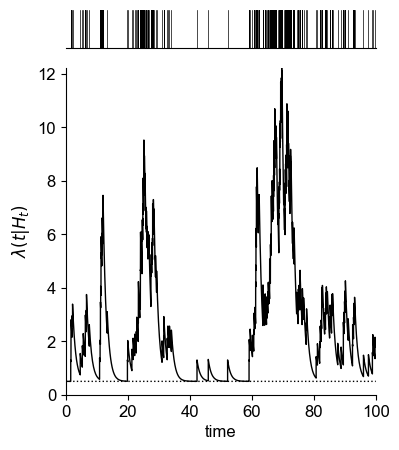

In [259]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':0.5, 'alpha':0.8, 'beta':1}
model.set_parameter(para)
itv = [0,100] # the observation interval
events = model.simulate(itv)
model.plot_l() 

initial_guess = np.array([1,1,1])
#jac=calculate_gradient, hess=calculate_hessian,
final_guess = minimize(maximise_llh, initial_guess, events, jac=calculate_gradient, hess=calculate_hessian, options={'return_all':True}, method="Nelder-Mead")

mses += [np.sqrt((final_guess.x[0] - 0.8)**2 + (final_guess.x[0] - 1)**2) + (final_guess.x[0] - 0.5)**2]

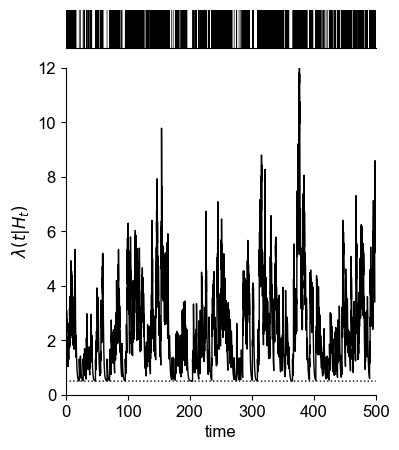

In [260]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':0.5, 'alpha':0.8, 'beta':1}
model.set_parameter(para)
itv = [0,500] # the observation interval
events = model.simulate(itv)
model.plot_l() 

initial_guess = np.array([1,1,1])
#jac=calculate_gradient, hess=calculate_hessian,
final_guess = minimize(maximise_llh, initial_guess, events, jac=calculate_gradient, hess=calculate_hessian, options={'return_all':True}, method="Nelder-Mead")

mses += [np.sqrt((final_guess.x[0] - 0.8)**2 + (final_guess.x[0] - 1)**2) + (final_guess.x[0] - 0.5)**2]

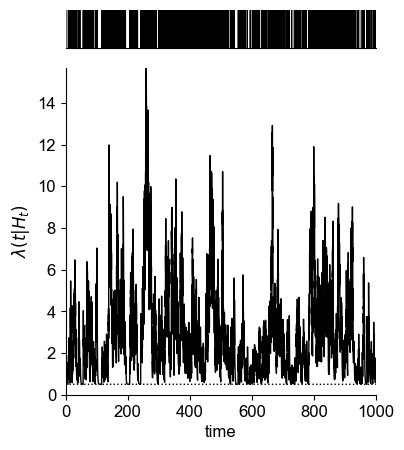

In [261]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':0.5, 'alpha':0.8, 'beta':1}
model.set_parameter(para)
itv = [0,1000] # the observation interval
events = model.simulate(itv)
model.plot_l() 

initial_guess = np.array([1,1,1])
#jac=calculate_gradient, hess=calculate_hessian,
final_guess = minimize(maximise_llh, initial_guess, events, jac=calculate_gradient, hess=calculate_hessian, options={'return_all':True}, method="Nelder-Mead")

mses += [np.sqrt((final_guess.x[0] - 0.8)**2 + (final_guess.x[0] - 1)**2) + (final_guess.x[0] - 0.5)**2]

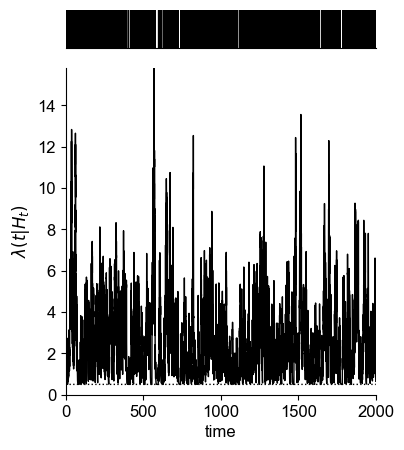

In [262]:
model = hk.simulator()
model.set_kernel('exp')
model.set_baseline('const')
para = {'mu':0.5, 'alpha':0.8, 'beta':1}
model.set_parameter(para)
itv = [0,2000] # the observation interval
events = model.simulate(itv)
model.plot_l() 

initial_guess = np.array([1,1,1])
#jac=calculate_gradient, hess=calculate_hessian,
final_guess = minimize(maximise_llh, initial_guess, events, jac=calculate_gradient, hess=calculate_hessian, options={'return_all':True}, method="Nelder-Mead")

mses += [np.sqrt((final_guess.x[0] - 0.8)**2 + (final_guess.x[0] - 1)**2) + (final_guess.x[0] - 0.5)**2]

In [263]:
mses

[1.4352126119911013, 0.292561969348788, 0.3123671973462509, 0.2941281304066312]

In [265]:
final_guess.x

array([0.79045124, 0.99186698, 0.47246852])

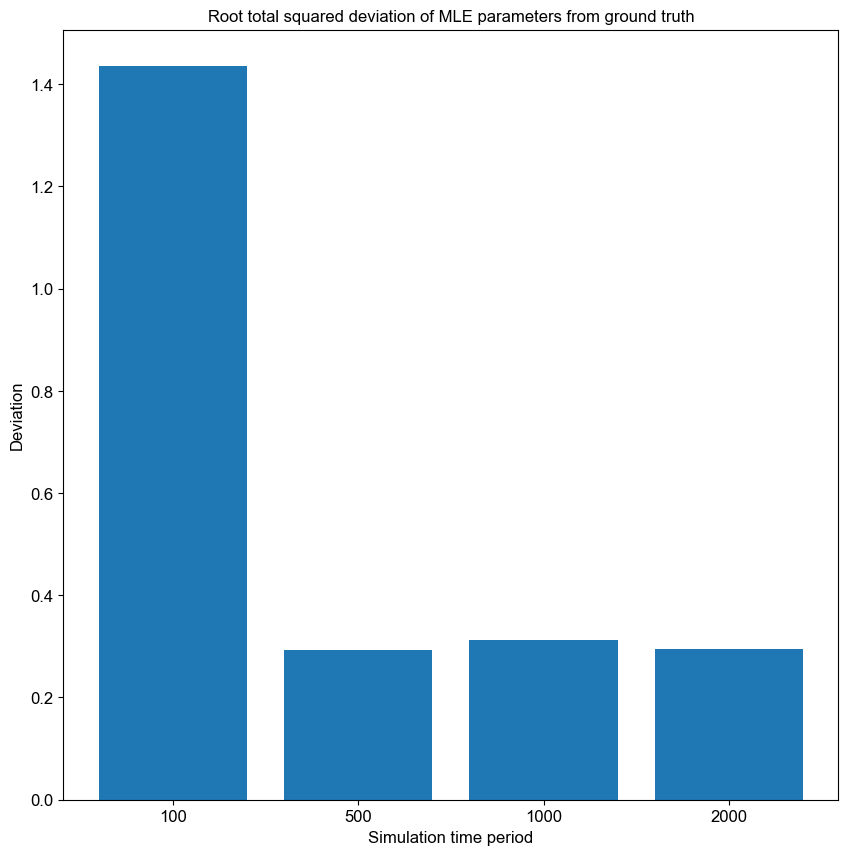

In [267]:
plt.figure(figsize=(10,10))
plt.bar(range(len(mses)), mses)

plt.title("Root total squared deviation of MLE parameters from ground truth")
plt.ylabel("Deviation")
plt.xlabel("Simulation time period")

plt.xticks(range(len(mses)), [100, 500, 1000, 2000])

plt.show()

# Maximum likelihood fitting of a Multivariate Hawkes process

In [2]:
adjacency = np.array([[0.4, 0.4],
                      [0.4, 0.4]], dtype="float")

decays = np.array([[0.2, 0.2],
                    [0.2, 0.2]], dtype="float")

baseline = np.array([0.4, 0.4], dtype="float")

In [3]:
sim1 = hp.SimuHawkesExpKernels(adjacency, decays, baseline=baseline, end_time=500, force_simulation=True)

In [4]:
sim1.spectral_radius()

array(0.8)

In [5]:
events = sim1.simulate()

--------------------------------------------------
Launching simulation using SimuHawkesExpKernels...
Done simulating using SimuHawkesExpKernels in 1.34e-03 seconds.


In [6]:
sim1.timestamps

[array([  4.033815  ,   4.2381827 ,   6.09101886,   6.46216075,
          7.13567113,   7.84903908,  12.78812165,  14.28095341,
         14.68484981,  14.71312901,  15.74621702,  15.7805401 ,
         16.68198162,  23.88791291,  24.58765283,  25.873348  ,
         27.67592046,  27.76346892,  28.63475564,  29.01737181,
         32.08798555,  32.28502908,  32.36648216,  32.63720902,
         32.70165032,  32.78932007,  33.01103582,  33.87912579,
         33.99879649,  34.57397334,  37.80505473,  37.86132117,
         38.88359193,  38.98606473,  39.32477214,  39.54057968,
         40.44175684,  40.47135928,  41.01745475,  43.39387268,
         43.59611446,  43.75849219,  43.98170283,  46.11502589,
         46.13499218,  47.52431069,  47.68486336,  48.92335091,
         49.46226099,  49.6161298 ,  50.34960104,  51.90050755,
         54.27176858,  54.50712764,  54.88323022,  57.9175597 ,
         58.00619379,  59.14624249,  60.13869185,  60.42386595,
         61.66727496,  61.66745753,  63.

In [7]:
from tick.hawkes import HawkesExpKern


In [14]:
learner = HawkesExpKern(0.2)

In [15]:
res = learner.fit(sim1.timestamps)

In [16]:
res.adjacency

array([[0.46230879, 0.36284684],
       [0.4672336 , 0.27818354]])

In [17]:
res.baseline

array([0.36048332, 0.54520644])

In [11]:
help(res)

Help on HawkesExpKern in module tick.hawkes.inference.hawkes_expkern_fixeddecay object:

class HawkesExpKern(tick.hawkes.inference.base.learner_hawkes_param.LearnerHawkesParametric)
 |  HawkesExpKern(decays, gofit='least-squares', penalty='l2', C=1000.0, solver='agd', step=None, tol=1e-05, max_iter=100, verbose=False, print_every=10, record_every=10, elastic_net_ratio=0.95, random_state=None)
 |  
 |  Hawkes process learner for exponential kernels with fixed and given decays,
 |  with many choices of penalization and solvers.
 |  
 |  Hawkes processes are point processes defined by the intensity:
 |  
 |  .. math::
 |      \forall i \in [1 \dots D], \quad
 |      \lambda_i(t) = \mu_i + \sum_{j=1}^D
 |      \sum_{t_k^j < t} \phi_{ij}(t - t_k^j)
 |  
 |  where
 |  
 |  * :math:`D` is the number of nodes
 |  * :math:`\mu_i` are the baseline intensities
 |  * :math:`\phi_{ij}` are the kernels
 |  * :math:`t_k^j` are the timestamps of all events of node :math:`j`
 |  
 |  and with an expone

In [68]:
def hawkes_kernel(time_1, other_times, alpha, beta):
    time_diff = time_1 - other_times
    time_diff = time_diff[time_diff > 0]
    return alpha*np.exp(-beta*time_diff).sum()

In [69]:
def hawkes_kernel_c(time_1, other_times, alpha, beta):
    time_diff = time_1 - other_times
    time_diff = time_diff[time_diff > 0]
    return alpha*(np.exp(-beta*time_diff) - 1).sum()

In [70]:
def hawkes_kernel_(time_1, other_times, alpha, beta):
    time_diff = time_1 - other_times
    time_diff = time_diff[time_diff > 0]
    return alpha*(time_diff*np.exp(-beta*time_diff)).sum()

In [71]:
def hawkes_kernel__c(time_1, other_times, alpha, beta):
    time_diff = time_1 - other_times
    time_diff = time_diff[time_diff > 0]
    return alpha*(time_diff*(np.exp(-beta*time_diff) - 1)).sum()

In [72]:
def component_wise_likelihood(k, events, baseline, alpha_vector, beta_vector, curr_component):
    curr_events = events[curr_component]
    log_like = 0
    mu = baseline[curr_component]

    for event in curr_events:
        like = 0
        like += mu
        for j in range(k):
            alpha = alpha_vector[j]
            beta = beta_vector[j]
            like += hawkes_kernel(event, events[j], alpha, beta)*beta
        log_like += np.log(like)
    return log_like

In [73]:
def compensator_likelihood(events, baseline, alpha_vector, beta_vector, curr_component, final_time):
    log_like = 0

    for j, event_list in enumerate(events):
        alpha = alpha_vector[j]
        beta = beta_vector[j]
        log_like += hawkes_kernel_c(final_time, event_list, alpha, beta)

    return log_like - baseline[curr_component]*final_time

In [74]:
def calculate_log_likelihood_multivariate_hp(k, events, baselines, adjacency, decays, final_time):
    log_likelihood = 0

    for d in range(k):
        log_likelihood += component_wise_likelihood(k, events, baselines, alpha_vector=adjacency[d], beta_vector=decays[d], curr_component=d)
        log_likelihood += compensator_likelihood(events, baselines, alpha_vector=adjacency[d], beta_vector=decays[d], curr_component=d, final_time=final_time)
    return log_likelihood

In [75]:
def calculate_alpha_gradient(d, k, alphas, betas, mus, events, final_time):
    events_d = events[d]
    events_k = events[k]
    alpha = alphas[d][k]
    beta = betas[d][k]
    mu = mus[d]

    grad = hawkes_kernel_c(final_time, events_k, alpha, beta)/alpha

    for event in events_d:
        num = hawkes_kernel(event, events_k, alpha, beta)*(beta/alpha)
        den = mu
        for k_ in range(len(events)):
            alpha_ = alphas[d][k_]
            beta_ = betas[d][k_]
            den += hawkes_kernel(event, events[k_], alpha_, beta_)*beta_
        grad += (num/den)
    
    return grad

In [76]:
def calculate_mu_gradient(d, k, alphas, betas, mus, events, final_time):
    events_d = events[d]
    # events_k = events[k]
    # alpha = alphas[d][k]
    # beta = betas[d][k]
    mu = mus[d]

    grad = 0

    for event in events_d:
        num = 1
        den = mu
        for k_ in range(len(events)):
            alpha_ = alphas[d][k_]
            beta_ = betas[d][k_]
            den += hawkes_kernel(event, events[k_], alpha_, beta_)*beta_
        grad += (num/den)
    
    return grad - final_time

In [77]:
def calculate_beta_gradient(d, k, alphas, betas, mus, events, final_time):
    events_d = events[d]
    events_k = events[k]
    alpha = alphas[d][k]
    beta = betas[d][k]
    mu = mus[d]

    grad = -hawkes_kernel_(final_time, events_k, alpha, beta)

    for event in events_d:
        num = -beta*hawkes_kernel_(event, events_k, alpha, beta) + hawkes_kernel(event, events_k, alpha, beta)
        den = mu
        for k_ in range(len(events)):
            alpha_ = alphas[d][k_]
            beta_ = betas[d][k_]
            den += hawkes_kernel(event, events[k_], alpha_, beta_)*beta_
        grad += (num/den)
    
    return grad

In [78]:
def calculate_gradients(x, events, k, final_time):

    param_dim = k**2
    adjacency = x[:param_dim].reshape(k,k)
    decays = x[param_dim : param_dim*2].reshape(k,k)
    baselines = x[-k:]
    
    alpha_grads = np.zeros((k,k))
    beta_grads = np.zeros((k,k))
    mu_grads = np.zeros(k,)

    for i in range(k):
        # calculate mu gradient
        mu_grads[i] = calculate_mu_gradient(i, None, adjacency, decays, baselines, events, final_time)
        for j in range(k):
            # calculate alpha gradient
            alpha_grads[i][j] += calculate_alpha_gradient(i, j, adjacency, decays, baselines, events, final_time)
            # calculate beta gradient
            beta_grads[i][j] += calculate_beta_gradient(i, j, adjacency, decays, baselines, events, final_time)

    return -np.concatenate([alpha_grads.flatten(), beta_grads.flatten(), mu_grads])/final_time

In [79]:
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

/Users/yuwei-1/anaconda3/envs/tick/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in log
  del sys.path[0]


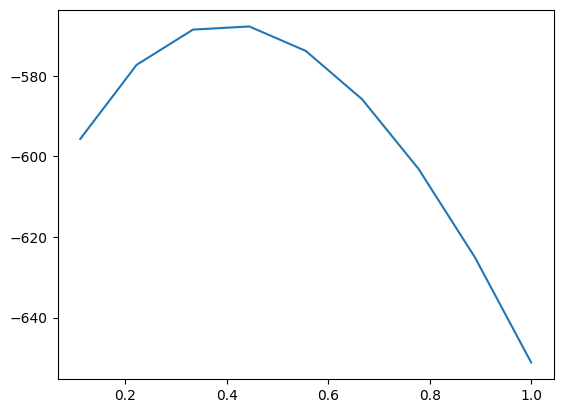

In [83]:
# sanity check

y = []

for x in np.linspace(0, 1, 10):
    mus = np.array([x, x])
    y += [calculate_log_likelihood_multivariate_hp(2, sim1.timestamps, mus, adjacency, decays, 500)]

plt.plot(figsize=(10,10))
plt.plot(np.linspace(0, 1, 10), y)
plt.show()

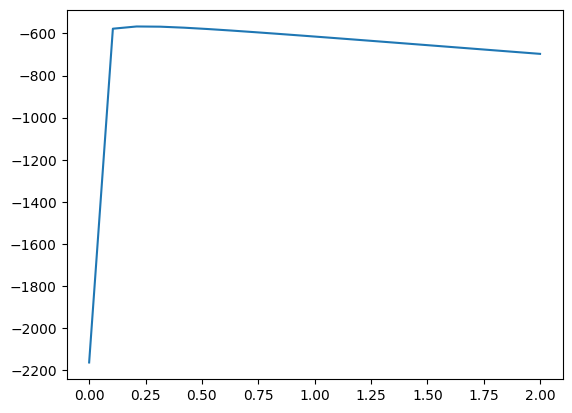

In [84]:
# sanity check

y = []

for x in np.linspace(0, 2, 20):
    betas = np.array([[x, x],
                     [x, x]])
    y += [calculate_log_likelihood_multivariate_hp(2, sim1.timestamps, baseline, adjacency, betas, 500)]

plt.plot(figsize=(10,10))
plt.plot(np.linspace(0, 2, 20), y)
plt.show()

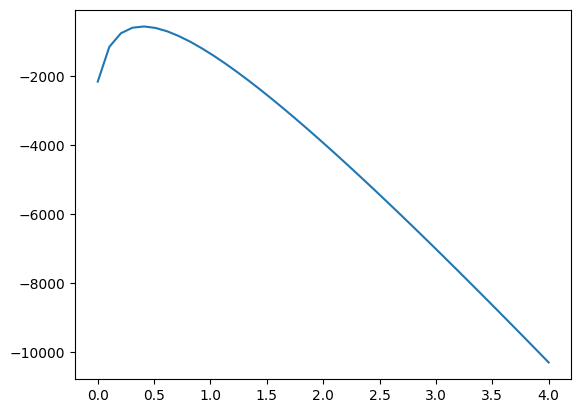

In [85]:
# sanity check

y = []

for x in np.linspace(0, 4, 40):
    alphas = np.array([[x, x],
                     [x, x]])
    y += [calculate_log_likelihood_multivariate_hp(2, sim1.timestamps, baseline, alphas, decays, 500)]

plt.plot(figsize=(10,10))
plt.plot(np.linspace(0, 4, 40), y)
plt.show()

In [86]:
def multivariate_hp_sklearn_wrapper(x, events, k, last_time):
    param_dim = k**2
    
    adjacency = x[:param_dim].reshape(k,k)
    decays = x[param_dim : param_dim*2].reshape(k,k)
    mus = x[-k:]

    # adjacency = np.ones((k,k))*x[0]
    # decays = np.ones((k,k))*x[1]
    # mus = np.array(k*[x[2]])

    return -calculate_log_likelihood_multivariate_hp(k, events, mus, adjacency, decays, last_time)/last_time

In [87]:
k = 2
x0 = np.ones(2*k**2 + k)
bounds = [(0, None)]*(2*k**2 + k)

In [88]:
calculate_gradients(x0, sim1.timestamps, k, 500)

array([1.15617506, 1.24817773, 1.0910836 , 1.19547461, 0.03903839,
       0.03688937, 0.03726447, 0.05315042, 0.59488116, 0.55667574])

In [89]:
res = minimize(multivariate_hp_sklearn_wrapper, x0, jac=calculate_gradients, args=(sim1.timestamps, k, 500), method="CG", bounds=bounds, options={"maxiter":1000})

/Users/yuwei-1/anaconda3/envs/tick/lib/python3.7/site-packages/scipy/optimize/_minimize.py:539: RuntimeWarning: Method CG cannot handle constraints nor bounds.
  RuntimeWarning)


In [90]:
res

     fun: 1.129018873199737
     jac: array([ 9.95038944e-07, -2.22150831e-07, -1.48353442e-06, -2.50996922e-06,
       -4.27032317e-07,  1.73252073e-07, -1.25418994e-06,  9.80702946e-07,
        1.65583694e-06, -9.23556272e-07])
 message: 'Optimization terminated successfully.'
    nfev: 57
     nit: 27
    njev: 57
  status: 0
 success: True
       x: array([0.35913614, 0.41037428, 0.44561902, 0.33723154, 0.2446017 ,
       0.23599302, 0.25551629, 0.24937365, 0.37033548, 0.51265809])

In [91]:
res.x

array([0.35913614, 0.41037428, 0.44561902, 0.33723154, 0.2446017 ,
       0.23599302, 0.25551629, 0.24937365, 0.37033548, 0.51265809])

In [ ]:
0.4, 0.4, 0.4, 0.4, 0.2, 0.2, 0.2, 0.2, 0.4, 0.4